# Titanic survival prediction

---
We will predict the survival of a person based on given set of attributes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from IPython.display import HTML
import warnings
import matplotlib.style as style 
# style.available


In [2]:
def numericValues(pdSeries, fillNullValues = True):
    itemNo = 0
    for item in pdSeries.unique():
        if pd.notna(item):
            pdSeries = pdSeries.replace(item,itemNo)
        elif fillNullValues:
            pdSeries = pdSeries.fillna(itemNo)
        itemNo+=1
    return pdSeries

In [3]:
trainData = pd.read_csv('./train.csv')
testData = pd.read_csv('./test.csv')
survivedData = pd.read_csv('./gender_submission.csv')

In [4]:

print("Shape of data : "+str(trainData.shape))
cols = list(trainData.columns)
print("columns : "+str(cols))

Shape of data : (891, 12)
columns : ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']



---
So we have a dataset with 12 columns and 891 rows. We will now test these 12 columns to check how much effect they have in output variable.

---

In [5]:
(nRowsT,nColsT) = testData.shape
print("Shape of data : "+str(testData.shape))
colsTest = list(testData.columns)

print("columns : "+str(colsTest))
display(testData.head())
display(trainData.tail())
display(testData.info())

Shape of data : (418, 11)
columns : ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


None

In [6]:
combined = pd.concat([trainData.drop(columns='Survived'),testData])

In [7]:
(nRows,nCols) = combined.shape

In [8]:
combined.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
print("Total rows "+str(nRows))
print("Column-wise missing values:")
print(nRows-combined.count())

Total rows 1309
Column-wise missing values:
PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


### Data Cleaning: (Handling Null/Missing Values)
---
So there are 3 columns with missing values, namely, <code>Age</code> (177 missing values), <code>Cabin</code> (687) and <code>Embarked</code> (2). Let start simple with <code>Embarked</code> column and work our way up. 

In [10]:
#adding a column row count which will be useful in handling our data
combined['rowCount'] = np.ones(shape=combined.shape[0])
combined[combined["Embarked"].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,rowCount
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1.0
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1.0


In [11]:
combined.groupby("Embarked", as_index=False).rowCount.count()

,Embarked,rowCount
0,C,270
1,Q,123
2,S,914


We see that the majority of the passengers embarked from Southhampton (S), hence we will assume that these two passengers also embarked from Southhampton. 

In [12]:
combined["Embarked"] = combined.Embarked.fillna("S")
combined.Embarked.count()

1309

Now we will move on to <code>Age</code> which is having 177 missing values. This is tricky part as we have 177 null values and we cannot just assign any random value for <code>Age</code>, as such large number will surely affect the result. What we can do here is assign the mean to the missing values: 

In [13]:
combined["Age"] = combined["Age"].fillna(combined.groupby(["Sex","Pclass","Embarked"]).Age.transform('mean'))
combined.Age.count()

1309

In [14]:
combined["Fare"] = combined.Fare.fillna(combined.Fare.mean())

Now we are left with column <code>Cabin</code>, which have 644 (~72.3%) out of possible 891 values are missing from the data. We can extract from this a column <code>hasCabin</code>, which could be helpful for model,

In [15]:
combined['hasCabin'] = ~combined.Cabin.isnull()
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
rowCount       1309 non-null float64
hasCabin       1309 non-null bool
dtypes: bool(1), float64(3), int64(4), object(5)
memory usage: 134.2+ KB


So, we are done with missing values. Feels great, right?<br>
Now we will look into Name column of the data...

---

In [16]:
print(combined.Name.head())

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object


Name of a person may not give that much information about their survival, because hey! you don't get to survive if your likeable. Nobody is asking you your name when the ship is sinking. However, one thing that can be of value is the <i>title</i>. A person's title can be a reflection of their social status, which for a good reason can be an important factor in survival.  

In [17]:
combined['Title'] = combined.Name.apply(lambda x:re.search(" [A-Z][a-z]+\.",x).group())

In [18]:
combined['Title'].unique()

array([' Mr.', ' Mrs.', ' Miss.', ' Master.', ' Don.', ' Rev.', ' Dr.',
       ' Mme.', ' Ms.', ' Major.', ' Lady.', ' Sir.', ' Mlle.', ' Col.',
       ' Capt.', ' Countess.', ' Jonkheer.', ' Dona.'], dtype=object)

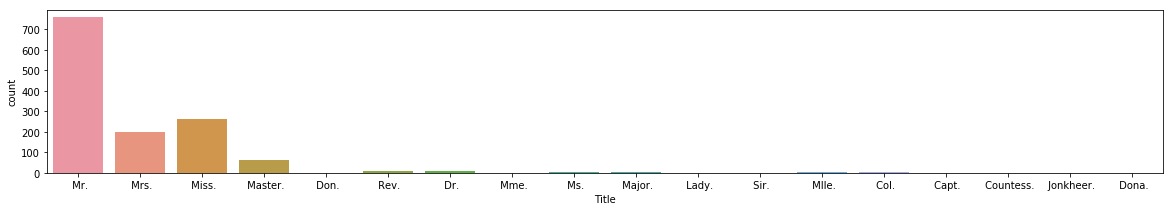

In [19]:
plt.rcParams['figure.figsize']=(20,3)
sns.countplot(x='Title',data=combined)

So, now that we have the <code>Title</code> column we can see the there is a lot of variance the frequency of the <code>Title</code>. What we can do is map the <code>Title</code> values to smaller set. For this we can change the french titles to english and group title with smaller frequencies in one group <i>special</i>

['Mr.' 'Mrs.' 'Miss.' 'Master.' 'special']
Mr.        757
Miss.      264
Mrs.       198
Master.     61
special     29
Name: Title, dtype: int64


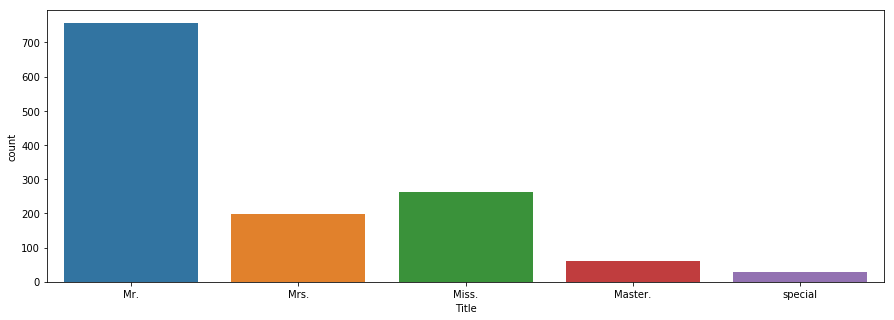

In [20]:
combined['Title'] = combined.Title.replace({' Mlle.':'Miss.',' Mme.':'Mrs.',' Ms.':'Miss.',' Mr.':'Mr.', \
                                              ' Master.':'Master.', ' Miss.':'Miss.', ' Mrs.':'Mrs.'})
combined['Title'] = combined.Title.replace([' Don.',' Rev.',' Dr.',' Major.',' Lady.',' Sir.',' Col.',' Capt.',\
                                              ' Countess.',' Jonkheer.',' Dona.'],'special')
print(combined.Title.unique())
print(combined.Title.value_counts())

plt.rcParams['figure.figsize']=(15,5)
sns.countplot(x='Title',data=combined)

Great Job! We extracted a feature from an existing one.

---

Let us now work on categorical variable encoding

In [21]:
print(combined.Sex.unique())

['male' 'female']


In [22]:
# numerical encoding for Sex
combined['Sex'] = np.where(combined.Sex=='male',0,1)
print(combined.Sex.unique())

[0 1]


In [23]:
print(combined.Embarked.unique())

['S' 'C' 'Q']


In [24]:
embarkedMap = {'S': 0, 'C': 1, 'Q': 2}
combined['Embarked'] = combined.Embarked.map(embarkedMap)
print(combined.Embarked.unique())

[0 1 2]


In [25]:
combined.Parch.max()

9

In [26]:
print(combined.Title.unique())

['Mr.' 'Mrs.' 'Miss.' 'Master.' 'special']


In [27]:
titleMap = {'Mr.':0, 'Mrs.':1, 'Miss.':2, 'Master.':3, 'special':4}
combined.Title = combined.Title.map(titleMap)
print(combined.Title.unique())

[0 1 2 3 4]


In [28]:
print("Min \n"+str(combined.min()))
print("-"*50)
print("Max \n"+str(combined.max()))

Min 
PassengerId                      1
Pclass                           1
Name           Abbing, Mr. Anthony
Sex                              0
Age                           0.17
SibSp                            0
Parch                            0
Ticket                      110152
Fare                             0
Embarked                         0
rowCount                         1
hasCabin                     False
Title                            0
dtype: object
--------------------------------------------------
Max 
PassengerId                           1309
Pclass                                   3
Name           van Melkebeke, Mr. Philemon
Sex                                      1
Age                                     80
SibSp                                    8
Parch                                    9
Ticket                           WE/P 5735
Fare                               512.329
Embarked                                 2
rowCount                                

Since we can see the range is not the same lets do some feature scaling...

In [29]:
print("Fare\nMax : "+str(combined.Fare.max())+"\nMin : "+str(combined.Fare.min()))

Fare
Max : 512.3292
Min : 0.0


In [30]:
# min-max scaling
if combined.Fare.ptp()!=0:
    combined.Fare -= combined.Fare.min()
    combined.Fare /= combined.Fare.ptp()
print("Fare\nMax : "+str(combined.Fare.max())+"\nMin : "+str(combined.Fare.min()))

Fare
Max : 1.0
Min : 0.0


---
Apart from Fare everything is in range 0 to <10, except Age. For age we will use binning as inddividual values might not be of much help than an age group. 

---

In [31]:
combined.Age = pd.cut(combined.Age, [0,10,20,30,40,50,60,np.inf], \
                       labels= ['0-10','10-20','20-30','30-40','40-50','50-60','60+'], include_lowest=True)
combined.Age.unique()

[20-30, 30-40, 50-60, 0-10, 10-20, 60+, 40-50]
Categories (7, object): [0-10 < 10-20 < 20-30 < 30-40 < 40-50 < 50-60 < 60+]

In [32]:
combined.Age = combined.Age.astype('str')

In [33]:
combined.Age.unique()

array(['20-30', '30-40', '50-60', '0-10', '10-20', '60+', '40-50'],
      dtype=object)

In [34]:
ageMap = {'20-30':2, '30-40':3, '50-60':5, '0-10':0, '10-20':1, '60+':6, '40-50':4}
combined.Age = combined.Age.map(ageMap)
print(combined.Age.unique())

[2 3 5 0 1 6 4]


Let's now remove unnecessary variables from the data which won't be of much help.

In [35]:
columnsToDrop = ['Name','Ticket','Cabin']
combined = combined.drop(columns=columnsToDrop)

In [36]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null int64
Age            1309 non-null int64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Fare           1309 non-null float64
Embarked       1309 non-null int64
rowCount       1309 non-null float64
hasCabin       1309 non-null bool
Title          1309 non-null int64
dtypes: bool(1), float64(2), int64(8)
memory usage: 153.8 KB


In [37]:
x_train = combined.iloc[:891,1:]
y_train = trainData.Survived
x_test = combined.iloc[891:,1:]
display(x_train.head())
display(y_train.head())
# print(x_train.shape)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,rowCount,hasCabin,Title
0,3,0,2,1,0,0.014151,0,1.0,False,0
1,1,1,3,1,0,0.139136,1,1.0,True,1
2,3,1,2,0,0,0.015469,0,1.0,False,2
3,1,1,3,1,0,0.103644,0,1.0,True,1
4,3,0,3,0,0,0.015713,0,1.0,False,0


0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [38]:
print(x_test.shape)
x_test.info()

(418, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 10 columns):
Pclass      418 non-null int64
Sex         418 non-null int64
Age         418 non-null int64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        418 non-null float64
Embarked    418 non-null int64
rowCount    418 non-null float64
hasCabin    418 non-null bool
Title       418 non-null int64
dtypes: bool(1), float64(2), int64(7)
memory usage: 33.1 KB


In [39]:
logRegr = LogisticRegression()
logRegr.fit(x_train,y_train)

/home/lokesh/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [40]:
y_predict = logRegr.predict(x_test)

In [43]:
confidencePercent = round(logRegr.score(x_train,y_train)*100,2)
print(confidencePercent)

81.37


In [44]:
y_test_Actual = survivedData['Survived'] 

In [45]:
print(logRegr.score(x_test,y_test_Actual))
submission =  pd.DataFrame({"PassengerId" : survivedData['PassengerId'], "Survived" : y_predict})
# submission.head()
submission.to_csv("./titanicPredictionLogReg.csv",index = False)

0.9282296650717703


In [41]:
def plotBar(data, x, y, title, xlabel=None, ylabel=None):
    style.use('seaborn-whitegrid')
    plt.rcParams['figure.figsize'] = [13,12]
#     print("before bar")
    sns.barplot(x=x,y=y,data=data)
#     print("after bar")
    plt.xlabel(xlabel if xlabel else x)
    plt.ylabel(ylabel if ylabel else y)
    plt.title(title)

Now this provides a lot of information. For instance, we can easily infer from first graph that gender might have been a very good factor in determing whether you make it out of the ship alive. However we will get a good picture if instead of numbers, we work with percentages.

### Inferences:
---
<b>Gender:</b> Female were more likely to survive the tragedy as compared to male. 233 out of a total of 314 females survived, which is 91.8% of the total female population. Whereas, only 109 male out of a total of 677 survived the sinking ship, which is a meagre 16.1% of male population.

<b>Embarked:</b> The bar charts are decieving in a sense in this case as the number of passenger embarked from <b>S</b> is quite large in comparison to other two stations. 

In [42]:
# len(trainData.Ticket.unique())
# style.available
trainData.max()


PassengerId                            891
Survived                                 1
Pclass                                   3
Name           van Melkebeke, Mr. Philemon
Sex                                   male
Age                                     80
SibSp                                    8
Parch                                    6
Ticket                           WE/P 5735
Fare                               512.329
dtype: object